# importing needed libraries

In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# load American youtube dataset

In [2]:
df=pd.read_csv("../input/youtube-trending-video-dataset/US_youtube_trending_data.csv")
df.head(n=2)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268787 entries, 0 to 268786
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           268787 non-null  object
 1   title              268787 non-null  object
 2   publishedAt        268787 non-null  object
 3   channelId          268787 non-null  object
 4   channelTitle       268787 non-null  object
 5   categoryId         268787 non-null  int64 
 6   trending_date      268787 non-null  object
 7   tags               268787 non-null  object
 8   view_count         268787 non-null  int64 
 9   likes              268787 non-null  int64 
 10  dislikes           268787 non-null  int64 
 11  comment_count      268787 non-null  int64 
 12  thumbnail_link     268787 non-null  object
 13  comments_disabled  268787 non-null  bool  
 14  ratings_disabled   268787 non-null  bool  
 15  description        264238 non-null  object
dtypes: bool(2), int64(5)

# data preprocessing

In [4]:
df.drop(["video_id","thumbnail_link"],inplace=True,axis=1)
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**download json file to show the category of id**

In [5]:
#We need to import json so that we can use its contents.

with open("../input/youtube-trending-video-dataset/IN_category_id.json") as f: categoryID = json.load(f)
categoryID, l_c = categoryID['items'], len(categoryID['items'])
ID_to_Category = dict(zip([int(categoryID[i]['id']) for i in range(l_c)],
                          [categoryID[i]['snippet']['title'] for i in range(l_c)]))
ID_to_Category

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [6]:
def clean_trending_date(date):
    y,m,d = date.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

In [7]:
df['trending_date'] = df['trending_date'].apply(clean_trending_date)
df['publishedAt'] = df['publishedAt'].apply(clean_publish_time)

df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


In [8]:
df.drop(df[(df['comments_disabled'] == True) | (df['ratings_disabled'] == True)].index, inplace=True)
df.drop(df[(df['likes'] == 0) & (df['dislikes'] == 0) & (df['comment_count'] == 0)].index, inplace=True)
df.drop(columns=['comments_disabled', 'ratings_disabled'], errors='ignore',inplace=True)

In [9]:
print(df.columns)

Index(['title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId',
       'trending_date', 'tags', 'view_count', 'likes', 'dislikes',
       'comment_count', 'description'],
      dtype='object')


In [10]:
df_c = df
df_c.head(n=2)


,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare..."


# adding Important Calculations

In [11]:
df_c['engagement_rate'] = (df_c['likes'] + df_c['dislikes'] + df_c['comment_count']) / (df_c['view_count'] + 1e-6)
df_c['like_dislike_ratio'] = df_c['likes'] / (df_c['dislikes'] + 1e-6)
df_c['comment_view_ratio'] = df_c['comment_count'] / (df_c['view_count'] + 1e-6)
df_c['dislikes_per_comment'] = df_c['dislikes'] / (df_c['comment_count'] + 1e-6)

# Calculate days_since_publication, likes_per_day, comments_per_day, view_velocity
df_c['trending_date'] = pd.to_datetime(df_c['trending_date'], format='%Y-%m-%d')
df_c['days_since_publication'] = (df_c['trending_date'] - pd.to_datetime(df_c['publishedAt'])).dt.days
df_c['likes_per_day'] = df_c['likes'] / (df_c['days_since_publication'] + 1e-6)
df_c['comments_per_day'] = df_c['comment_count'] / (df_c['days_since_publication'] + 1e-6)
df_c['view_velocity'] = np.log(df_c['view_count'] + 1) / (df_c['days_since_publication'] + 1)

In [12]:
df_c.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,engagement_rate,like_dislike_ratio,comment_view_ratio,dislikes_per_comment,days_since_publication,likes_per_day,comments_per_day,view_velocity
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,0.130777,26.798975,0.023315,0.165803,1,156907.843092,35312.964687,7.115336
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",0.069733,52.519327,0.006948,0.168832,1,146738.853261,16548.983451,7.341660


In [13]:
print(df_c.isna().sum())

title                        0
publishedAt                  0
channelId                    0
channelTitle                 0
categoryId                   0
trending_date                0
tags                         0
view_count                   0
likes                        0
dislikes                     0
comment_count                0
description               4447
engagement_rate              0
like_dislike_ratio           0
comment_view_ratio           0
dislikes_per_comment         0
days_since_publication       0
likes_per_day                0
comments_per_day             0
view_velocity                0
dtype: int64


# train and test split

In [14]:
# Convert 'publishedAt' column to datetime objects
df_c['publishedAt'] = pd.to_datetime(df_c['publishedAt'])

# Define date ranges
start_date_2020 = pd.to_datetime('2020-01-01')
end_date_2021 = pd.to_datetime('2021-12-31')
start_date_2022 = pd.to_datetime('2022-01-01')
start_date_2023 = pd.to_datetime('2023-01-01')

# Split the dataset into three based on the specified years
train_data = df_c[(df_c['publishedAt'] >= start_date_2020) & (df_c['publishedAt'] <= end_date_2021)]
test_data = df_c[(df_c['publishedAt'] >= start_date_2022) & (df_c['publishedAt'] <= start_date_2022 + pd.DateOffset(years=1, days=-1))]
# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (100776, 20)
Testing data shape: (72108, 20)


# model training

In [15]:
# Selecting features for training
features = ['view_count', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_dislike_ratio', 
            'comment_view_ratio', 'dislikes_per_comment', 'days_since_publication', 'likes_per_day', 
            'comments_per_day']

# Split the data into features and target variable
X_train = train_data[features]
y_train = train_data['view_velocity']

X_test = test_data[features]

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=132, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Extract the 'view_velocity' column from test_data
y_test = test_data['view_velocity']

# model evaluation

In [16]:
# Select features for testing
X_test = test_data[features]

# Make predictions on the test data
y_pred = model.predict(X_test)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({'Title': test_data['title'], 
                                   'Channel': test_data['channelTitle'],
                                   'Trending Date': test_data['trending_date'],
                                   'Actual View Velocity': test_data['view_velocity'],
                                   'Predicted View Velocity': y_pred})

# Display the prediction results
print(prediction_results)

                                                    Title  \
102391  Orange Bowl: Georgia Bulldogs vs. Michigan Wol...   
102393  Times Square 2022 Ball Drop in New York City: ...   
102396  Welcome to MOVE - A 30 Day Yoga Journey  |  Yo...   
102398  Happy New Year Live! 🎆 London Fireworks 2022 🔴...   
102399  Cotton Bowl: Alabama Crimson Tide vs. Cincinna...   
...                                                   ...   
176983              Dude Perfect vs. Luka Doncic (1-on-1)   
177913  Argentina and Lionel Messi are crowned World C...   
178160  Argentina and Lionel Messi are crowned World C...   
178379  Argentina and Lionel Messi are crowned World C...   
178581  Argentina and Lionel Messi are crowned World C...   

                      Channel Trending Date  Actual View Velocity  \
102391  ESPN College Football    2022-01-02              6.662381   
102393           News 19 WLTX    2022-01-02              6.655743   
102396      Yoga With Adriene    2022-01-02              6.5

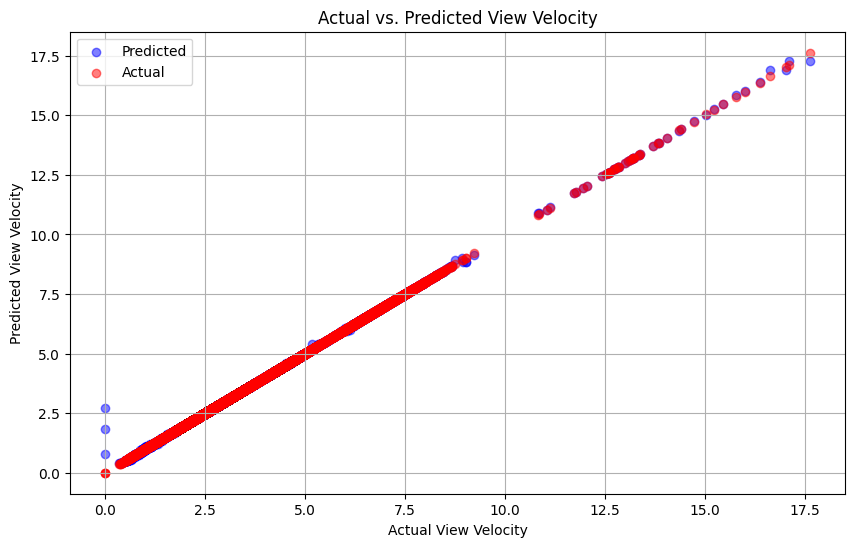

In [17]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Predicted View Velocity'], color='blue', label='Predicted', alpha=0.5)
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Actual View Velocity'], color='red', label='Actual', alpha=0.5)
plt.title('Actual vs. Predicted View Velocity')
plt.xlabel('Actual View Velocity')
plt.ylabel('Predicted View Velocity')
plt.legend()
plt.grid(True)
plt.show()